## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
import skimage.morphology
from IPython.display import HTML
from matplotlib import animation
import time

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.7.7
torch.__version__ -->  1.5.0


### Import the files

In [ ]:
params = load_json_as_dict("./RUN-MER-6/ML_parameters_MER_6.json")
ckpt = file2ckpt(path="./RUN-MER-6/last_ckpt_MER_6.pt", device=None)
#tiling = load_obj("./tiling.pt")

vae = CompositionalVae(params)
load_from_ckpt(ckpt=ckpt,
               model=vae,
               optimizer=None,
               overwrite_member_var=True)

In [ ]:
params

### Image to segment

In [ ]:
preprocessed = load_obj("streamlined_8_DAPI_Overview.tif")
img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()

fig, ax = plt.subplots(ncols=2, figsize=(12,12))
ax[0].imshow(img_torch[0, 0], cmap='gray')
ax[1].imshow(roi_mask_torch[0, 0])

### Compute the tiling

In [ ]:
with torch.no_grad():
    start_time = time.time()
    tiling: Segmentation = vae.segment_with_tiling(single_img=img_torch[0],
                                                   roi_mask=roi_mask_torch[0],
                                                   crop_size=(80,80),
                                                   stride=(20, 20),
                                                   n_objects_max_per_patch=None,
                                                   prob_corr_factor=0,
                                                   overlap_threshold=0.5,
                                                   radius_nn=10,
                                                   batch_size=128)
    print("tiling time",time.time()-start_time)
    

### Save of load the tiling

In [3]:
#save_obj(tiling, "./RUN-MER-6/tiling_large_MER_6.pt")
tiling = load_obj("./RUN-MER-6/tiling_large_MER_6.pt")

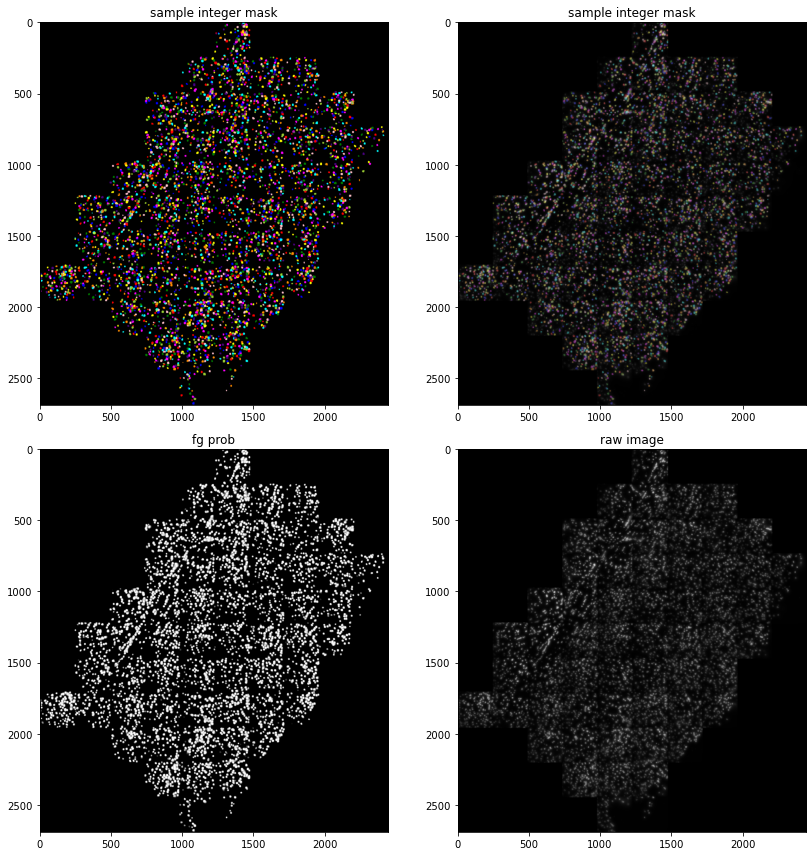

In [4]:
tiling_fig_large = plot_tiling(tiling, window=None, neptune_name=None)
tiling_fig_large

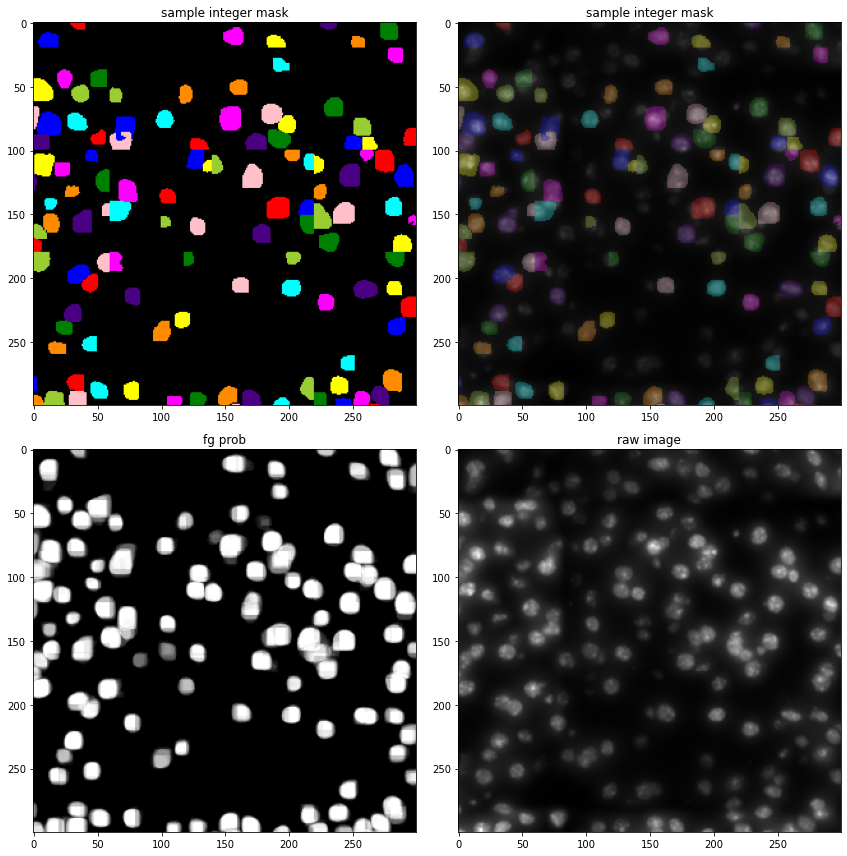

In [5]:
ix, iy, size = 940, 1140, 300
window = [ix, iy, ix+size, iy+size]
tiling_fig_small = plot_tiling(tiling, window=window, neptune_name=None)
tiling_fig_small

### Create graph

In [6]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=False)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

WARNING! You are going to create a graph without normalizing the edges by the sqrt of the node degree.                        Are you sure you know what you are doing?!
Building the graph with python-igraph
949896
54748808.0


'IGRAPH U-W- 949896 105054081 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

### Plot segmentation before graph approach

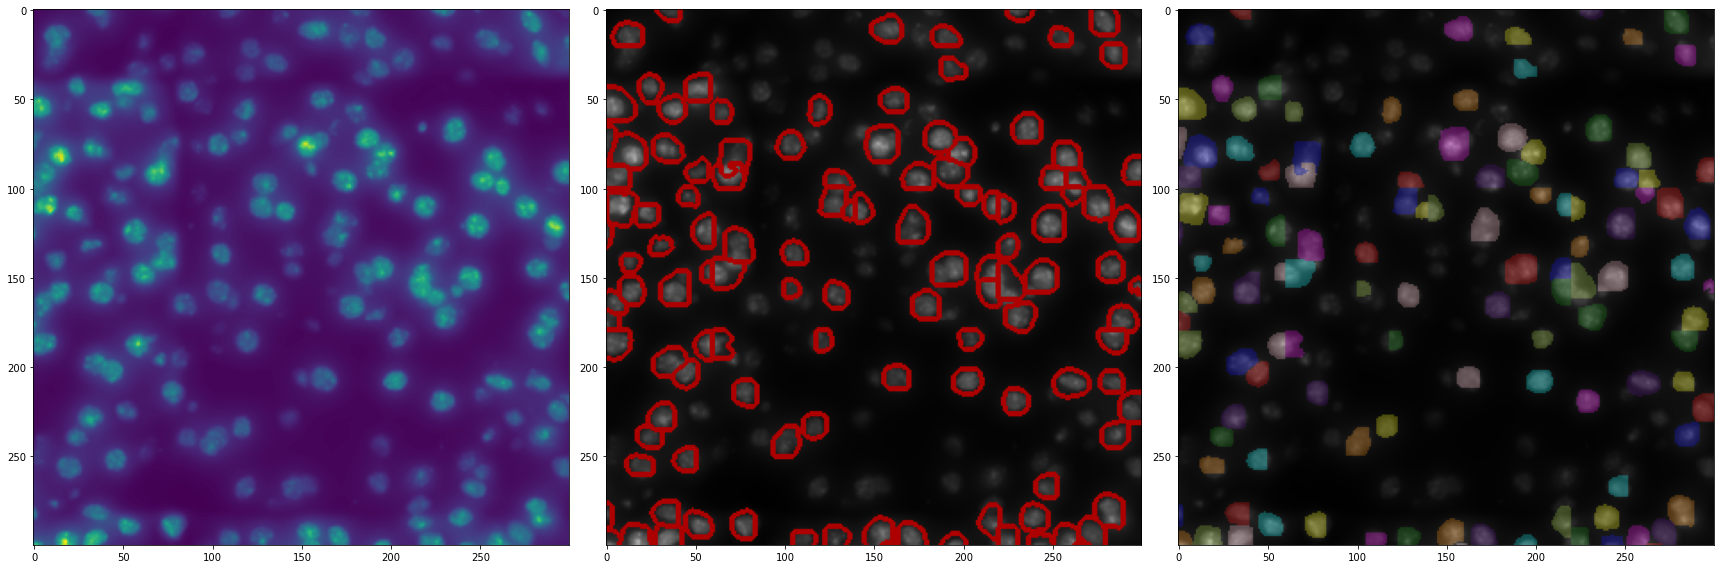

In [7]:
plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None) #"tiling_contours_graph")

### Perform sweep on a small window

In [ ]:
## sweep = numpy.arange(1.0, 20.0)
#sweep = numpy.linspace(start=1, stop=50, num=49)
#print(sweep)
#suggestion_mod_true = g.suggest_resolution_parameter(min_size=20,
#                                                     window=window,
#                                                     cpm_or_modularity="modularity",
#                                                     each_cc_separately=False,
#                                                     sweep_range=sweep)

In [14]:
# sweep = numpy.arange(1.0, 20.0)
sweep = numpy.linspace(start=50, stop=800, num=50)
print(sweep)
suggestion_mod_false = g.suggest_resolution_parameter(min_size=20,
                                                     window=window,
                                                     cpm_or_modularity="modularity",
                                                     each_cc_separately=False,
                                                     sweep_range=sweep)

[ 50.          65.30612245  80.6122449   95.91836735 111.2244898
 126.53061224 141.83673469 157.14285714 172.44897959 187.75510204
 203.06122449 218.36734694 233.67346939 248.97959184 264.28571429
 279.59183673 294.89795918 310.20408163 325.51020408 340.81632653
 356.12244898 371.42857143 386.73469388 402.04081633 417.34693878
 432.65306122 447.95918367 463.26530612 478.57142857 493.87755102
 509.18367347 524.48979592 539.79591837 555.10204082 570.40816327
 585.71428571 601.02040816 616.32653061 631.63265306 646.93877551
 662.24489796 677.55102041 692.85714286 708.16326531 723.46938776
 738.7755102  754.08163265 769.3877551  784.69387755 800.        ]
tensor([  0,   0,   0,  ..., 116, 117, 118], device='cuda:0')
resolution sweep,   0 out of  49
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resol

### See the sweep

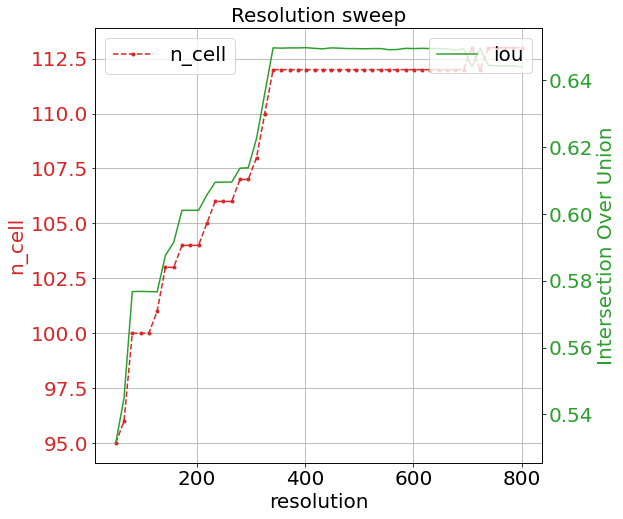

In [15]:
suggestion_mod_false.show_graph(figsize=(8,8))


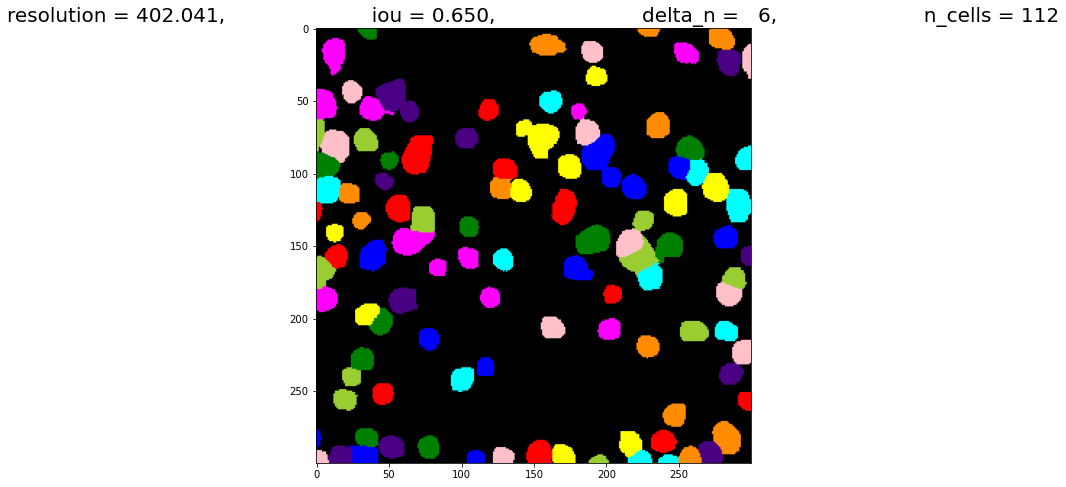

In [16]:
suggestion_mod_false.show_best(figsize=(8,8))

In [17]:
movie_from_resolution_sweep(suggestion_mod_false, tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]])

### Do community detection with the chiosen resolution parameter

In [18]:
import time
start_time = time.time()
resolution = 800.0

partition = g.find_partition_leiden(resolution=resolution, 
                                    min_size=20, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) 
print("community detection time",time.time()-start_time)

find partition internal
community detection time 821.0409157276154


### Vefiry results on the small window and check consistency

In [22]:
graph_integer_mask = g.partition_2_integer_mask(partition)
save_obj(graph_integer_mask, "graph_integer_mask_large.pt")
skimage.io.imsave("MERFISH_with_CONTOURS.tif", graph_integer_mask.cpu().numpy(), plugin=None, check_contrast=True)

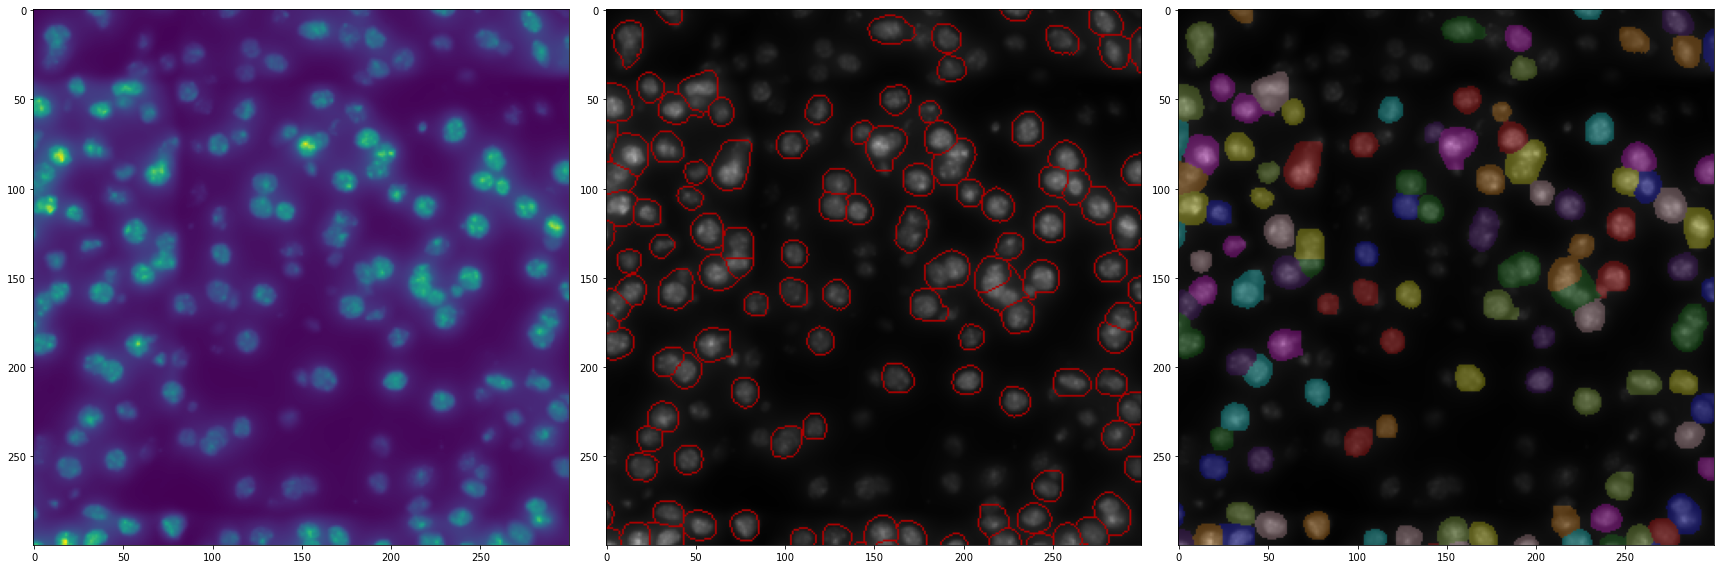

In [24]:
plot_label_contours(label=graph_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=1,
                    neptune_name=None)

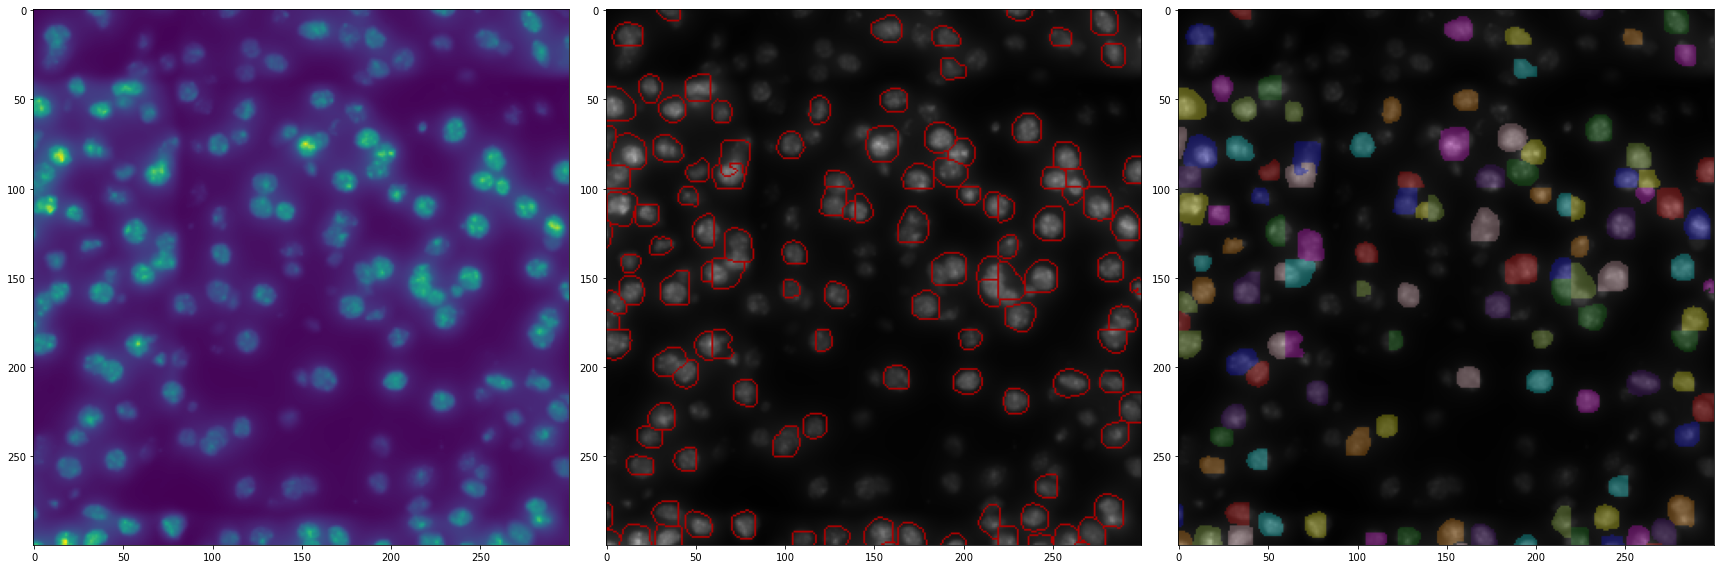

In [25]:
plot_label_contours(label=g.example_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=1,
                    neptune_name=None)

# FIGURE FOR PAPER

In [27]:
def contours_from_labels(labels: numpy.ndarray,
                         contour_thickness: int = 1) -> numpy.ndarray:
    assert isinstance(labels, numpy.ndarray)
    assert len(labels.shape) == 2
    assert contour_thickness >= 1
    contours = (skimage.morphology.dilation(labels) != labels)

    for i in range(1, contour_thickness):
        contours = skimage.morphology.binary_dilation(contours)
    return contours


def add_red_contours(image: numpy.ndarray, contours: numpy.ndarray):
    return draw_contours(image, contours, 'red')


def draw_contours(image: numpy.ndarray, contours: numpy.ndarray, contours_color: str = 'red') -> numpy.ndarray:
    assert isinstance(image, numpy.ndarray)
    assert isinstance(contours, numpy.ndarray)
    assert contours.dtype == bool
    if (len(image.shape) == 3) and (image.shape[-1] == 3):
        image_with_contours = image
    elif len(image.shape) == 2:
        image_with_contours = skimage.color.gray2rgb(image)
    else:
        raise Exception
    if contours_color == 'red':
        ch_index = 0
    elif contours_color == 'green':
        ch_index = 1
    elif contours_color == 'blue':
        ch_index = 2
    else:
        raise Exception("contours_color not recognized. Should be 'red' or 'green' or 'blue'")

    image_with_contours[contours, :] = 0
    image_with_contours[contours, ch_index] = numpy.max(image_with_contours)
    return image_with_contours

In [29]:
graph_integer_mask.shape

torch.Size([2688, 2444])

[940, 1140, 1240, 1440]


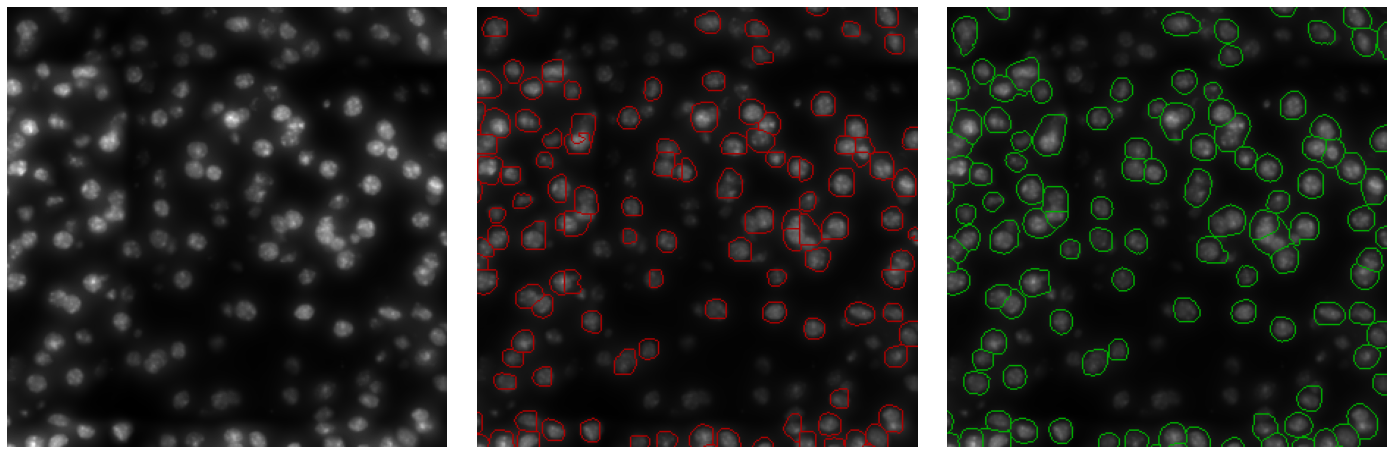

In [30]:
print(window)
raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

label_no_graph = tiling.integer_mask[0,0,window[0]:window[2], window[1]:window[3]].cpu().numpy()
c_no_graph = contours_from_labels(label_no_graph, contour_thickness=1)
seg_no_graph = draw_contours(image=raw_image, contours=c_no_graph, contours_color="red")

label_with_graph = graph_integer_mask[window[0]:window[2], window[1]:window[3]].cpu().numpy()
c_with_graph = contours_from_labels(label_with_graph, contour_thickness=1)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(raw_image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(seg_no_graph)
ax[1].axis('off')
ax[2].imshow(seg_with_graph)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./MERFISH.pdf")
fig.savefig("./MERFISH.png")

# CONTORUS DOWNSAMPLED

In [48]:
label_with_graph_all = graph_integer_mask.cpu().numpy()
raw_image_all = tiling.raw_image[0,0].cpu().numpy()

c_with_graph_all = contours_from_labels(label_with_graph_all, contour_thickness=1)
seg_with_graph_all = draw_contours(image=raw_image_all, contours=c_with_graph_all, contours_color="red")
skimage.io.imsave("MERFISH_contours_downsampled.tif", seg_with_graph_all, plugin=None, check_contrast=True)

In [53]:
seg_with_graph_all.shape

(2688, 2444, 3)

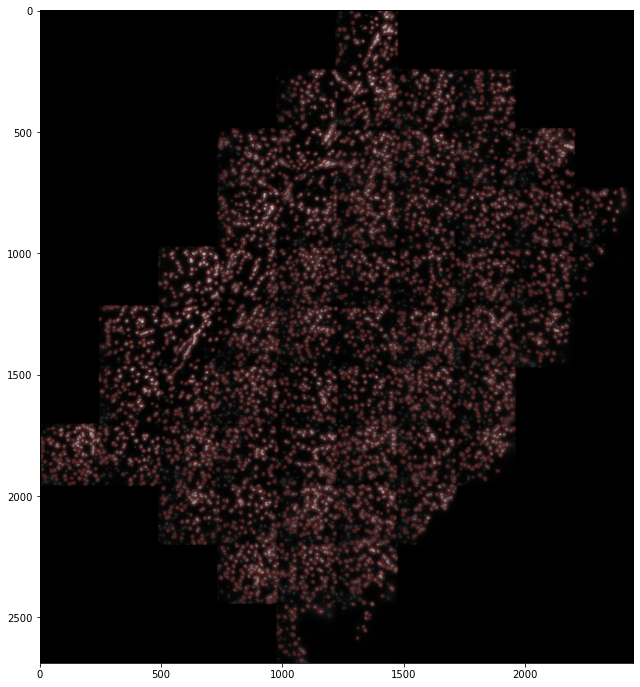

In [57]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(seg_with_graph_all)

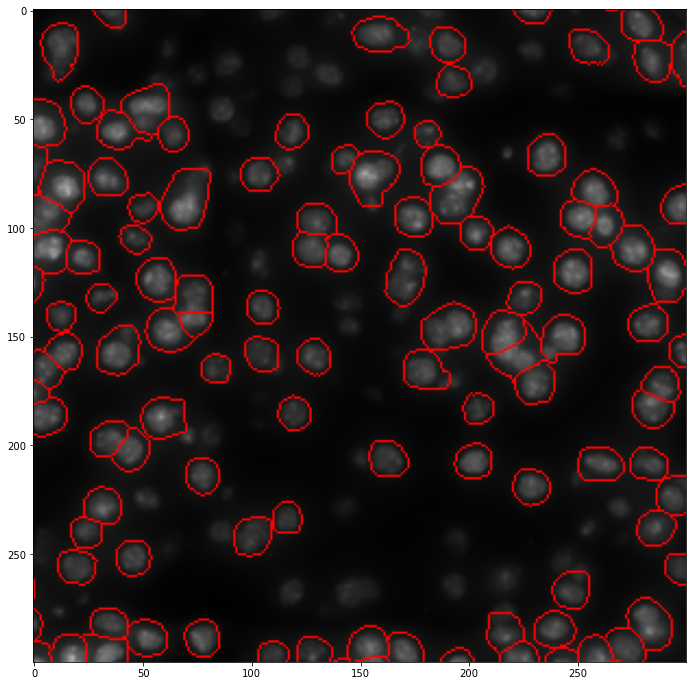

In [55]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(seg_with_graph_all[window[0]:window[2],window[1]:window[3]])

### SEG MASK ORIGINAL RESOLUTION

In [56]:
preprocessed_huge = load_obj("streamlined_1_DAPI_Overview.tif")
print(preprocessed_huge.img.shape)

torch.Size([1, 1, 21504, 19558])


In [58]:
luca_merfish_mask = skimage.transform.resize(label_with_graph_all, preprocessed_huge.img[0,0].shape,
                                             order=0, clip=True, preserve_range=True).astype(numpy.uint16)

In [59]:
skimage.io.imsave("MERFISH_segmask_highres.tif", luca_merfish_mask, plugin=None, check_contrast=True)

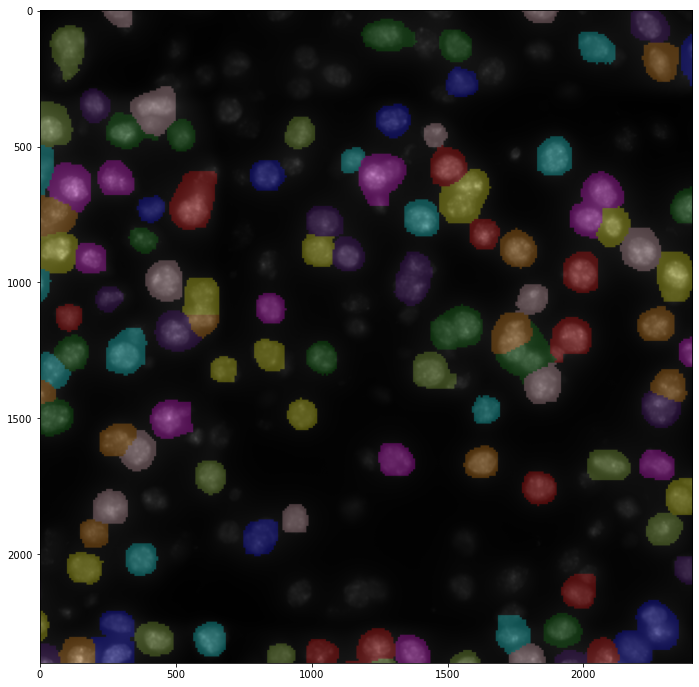

In [60]:
w = [window[0]*8, window[1]*8, window[2]*8, window[3]*8]


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(skimage.color.label2rgb(label=luca_merfish_mask[w[0]:w[2],w[1]:w[3]],
                                  image=preprocessed_huge.img[0,0,w[0]:w[2],w[1]:w[3]], 
                                  bg_label=0, alpha=0.25))

# Load results by Oleh for comparison

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform
import skimage.morphology
import skimage.exposure
import numpy
from typing import Optional
from MODULES.utilities_visualization import add_red_contours, contours_from_labels

In [ ]:
oleh_file = "oleh_big.tif"
luca_file = "luca_small.tif"
manual_file = "manual_annotation_big.tif"
raw_image_file = "smFISH_stitched_OLEH.tif"
luca_file_old = "segmentation_res800.tiff"

In [ ]:
raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(raw_image_file)))
oleh_label = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_label = skimage.io.imread(manual_file).astype(numpy.uint16)
luca_label_small = skimage.io.imread(luca_file).astype(numpy.uint16)
luca_label_old_small = skimage.io.imread(luca_file_old).astype(numpy.uint16)


In [ ]:
luca_label = skimage.transform.resize(luca_label_small, oleh_label.shape,
                                      order=0, clip=True, preserve_range=True).astype(numpy.uint16)
luca_label_old = skimage.transform.resize(luca_label_old_small, oleh_label.shape,
                                          order=0, clip=True, preserve_range=True).astype(numpy.uint16)

skimage.io.imsave("luca_big.tif", luca_label, plugin=None, check_contrast=True)
skimage.io.imsave("luca_big_old.tif", luca_label_old, plugin=None, check_contrast=True)

In [ ]:
c1 = contours_from_labels(luca_label_old, contour_thickness=3)
tmp1 = add_red_contours(raw_img, c1)
skimage.io.imsave("smFISH_contours_full_res.tif", tmp1, plugin=None, check_contrast=True)

In [ ]:
plt.imshow(raw_img)

In [ ]:
plt.imshow(luca_label)

In [ ]:
ROI_mask = skimage.morphology.convex_hull_image(luca_label > 0)
plt.imshow(ROI_mask)

In [ ]:
print(luca_label.shape)
print(oleh_label.shape)
print(gt_label.shape)
print(raw_img.shape)

### Plot comparisons

In [ ]:
def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        fraction = float(numpy.sum(ROI_mask[iw:iw+crop_size, ih:ih+crop_size]))/(iw*ih)
        if fraction<0.3 :
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window

def plot_comparison(raw_img: numpy.ndarray, 
                    labels1: numpy.ndarray, 
                    labels2: Optional[numpy.ndarray] = None, 
                    labels3: Optional[numpy.ndarray] = None,
                    window: Optional[list] = None, 
                    figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=3, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=3, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        l3 = labels3[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, contour_thickness=3)
        c2 = contours_from_labels(l2, contour_thickness=3)
        c3 = contours_from_labels(l3, contour_thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        tmp3 = add_red_contours(img, c3)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
            axs[row,2].imshow(tmp3, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            axs[2].imshow(tmp3, aspect='equal')

In [ ]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_label, luca_label_old, oleh_label, window=window, figsize=(24,24))